# Logistic Regression with a NN approach

Logistic regression image-recognition algorithm to recognize and classify pictures as cat or non-cat.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py                        # To interact with datasets stored on H5 files
import scipy
from PIL import Image              # To test the model against a customized picture
from scipy import ndimage

%matplotlib inline

C:\Users\Juanma\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_dataset():
    ''' This function loads the cat dataset from the h5 files '''
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # Train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # Train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])    # Test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])    # Test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Dataset ##

Contains:
 + Training set of m_train images labeled as cat (y=1) or non-cat (y=0)
 + Test set of m_test images labeled as cat or non-cat

Each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

In [3]:
# Loading the pre-processed data (cat/non-cat), with "_orig" prefix
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Each line of train_set_x_orig and test_set_x_orig is an array representing an image.

y = [1], it is a 'cat' picture.


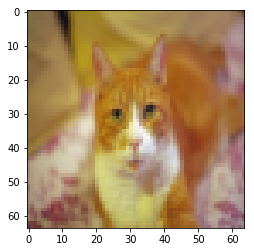

In [4]:
# Example of a picture (209 samples)
index = 24
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it is a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") +  "' picture.")

1- Dimensions of the dataset

In [5]:
# train_set_x_orig.shape(m_train, num_px, num_px, 3)

# Number of training samples
m_train = train_set_x_orig.shape[0]

# Number of test samples
m_test = test_set_x_orig.shape[0]

# Width / height of a training image (equal)
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


2- Resize the dataset

In [6]:
# Reshape training and test examples so images of size (num_px, num_px, 3) are flattened into
# vectors of shape (num_px * num_px * 3, 1), where each column represents a flattened image

# Flatten matrix of shape (a, b, c, d) to matrix of shape (b * c * d, a)
# m_train = 209; m_test = 50
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


3- Standardize the dataset

In [7]:
# Standardize by dividng every row by the maximum RGB value
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

## Architecture of the learning algorithm ##

Logistic regression is actually a very simple Neural Network.

**Mathematical expression of the algorithm**:

For one sample $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training samples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

## 4 - Algorithm ## 

1. Define the model structure (such as number of input features) 
2. Initialize the parameters of the model
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)
4. Predict the labels

### 4.1. Sigmoid function

Implement the sigmoid function: $z^{(i)} = 1 / (1+e^{-z^{(i)}})$

In [8]:
def sigmoid(z):
    '''Compute the sigmoid of z'''
    
    s = 1 / (1 + np.exp(-z))
    
    return s

In [9]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


### 4.2. Initializing parameters

In [12]:
def initialize_with_zeros(dim):
    '''
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    Dim is the number of parameters
    '''
    
    w = np.zeros((dim, 1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [13]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 4.3. Forward and Backward propagation

The "forward" and "backward" propagation steps are used for learning the parameters.

Forward Propagation:
- Get X
- Compute activation: $$ A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})\tag{5}$$
- Calculate the cost function: $$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})\tag{6}$$

Backward Propagation: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [14]:
def propagate(w, b, X, Y):
    
    ''' Cost function and its gradient for the propagation

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
    
    '''
    
    # Number of samples
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)

    # Activation
    A = sigmoid(np.dot(w.T, X) + b)
    
    # Cost: negative log-LH cost for logistic regression (eq 6)
    cost = (-1 / m) * np.sum((Y * np.log(A)) + ((1 - Y) * np.log(1 - A)), axis = 1)

    
    # BACKWARD PROPAGATION (to find gradient of the w and b parameters)
    
    # Gradient of the loss with respect to w (same shape as w) (eq 7)
    dw = (1 / m) * np.dot(X, (A - Y).T)
    
    # Gradient of the loss with respect to b (same shape as b) (eq 8)
    db = (1 / m) * np.sum(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [15]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


### 4.4. Update parameters

- Gradient descent step (numerical optimization)

- Learn $w$ and $b$ by minimizing the cost function $J$. 

- For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [16]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    '''
    
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    '''
    
    # Costs computed during the optimization, used later to plot the learning curve
    costs = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation for the current parameters
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from gradients
        dw = grads["dw"]
        db = grads["db"]
        
        # Update parameters
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    
    # Dict containing the weights w and bias b
    params = {"w": w,
              "b": b}
    # Dict containing the gradients of the weights and bias with respect to the cost function
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [17]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, 
                                learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


### 4.5. Prediction

Use the learned parameters w and b to predict the labels for a test dataset X

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5) and store the predictions in a vector `Y_prediction`

In [18]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    '''
    
    # Number of samples
    m = X.shape[1]
    
    # Numpy array (vector) containing all predictions (0/1) for the examples in X
    Y_prediction = np.zeros((1, m))
    
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    # Convert probabilities a[0,i] to actual predictions p[0,i]
    for i in range(A.shape[1]):
        
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
            
        else:
            Y_prediction[0,i] = 0
        
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [19]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


## 5. Logistic regression model ##

In [20]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    
    '''
    
    Builds the logistic regression model
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    '''
    
    # Initialize parameters
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    # Dictionary with information about the model
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

**Run the full model**

In [21]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


- Training accuracy is close to 100%, which means that the model is working and has high enough capacity to fit the training data. 

- Test error is 70%, which is not bad given the small dataset and that logistic regression is a linear classifier.

- The model is clearly overfitting the training data.

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

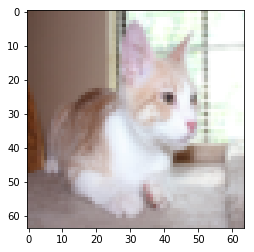

In [29]:
# Example of a picture that was wrongly classified.
index = 4
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0, index]) + ", you predicted that it is a \"" + 
       classes[d["Y_prediction_test"][0, index]].decode("utf-8") +  "\" picture.")

Plot the cost function and the gradients.

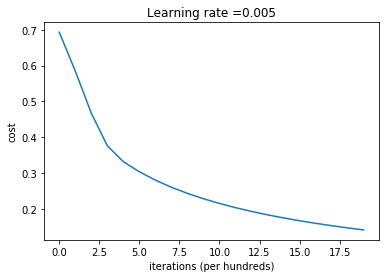

In [30]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

The cost decreases and the parameters are being learned. If the number of iterations is increased, the training set goes up, but the test set accuracy goes down (overfitting)

## 6. Choice of the learning rate ##

The learning rate (how rapidly we update the parameters) must be chosen correctly in order for Gradient Descent to work.
- If the learning rate is too large, the optimal value may be "overshoot". 
- If it is too small, too many iterations are needed to converge to the best values. 

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



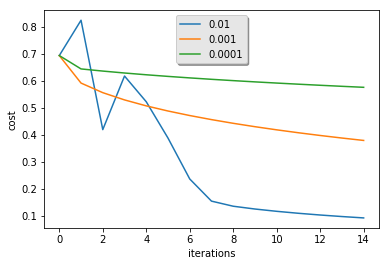

In [31]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge, although in this example, using 0.01 still eventually ends up at a good value for the cost.
- A lower cost does not mean a better model, as there might be overfitting (this happens when the training accuracy is a much higher than the test accuracy).
- In deep learning, it is recommended to:
    - Choose the learning rate that better minimizes the cost function.
    - If the model overfits, use other techniques to reduce overfitting.
